## Optimizing for Image Similarity using JAX

The following is an implementation of the **Ray Tracing in One Weekend**, *Peter Shirley*, 2020, https://raytracing.github.io/books/RayTracingInOneWeekend.html, guide to ray tracing using JAX.
To increase the speed of the raytracing, we employ the same "tricks" as have been laid out in https://www.excamera.com/sphinx/article-ray.html (Code available here: https://github.com/jamesbowman/raytrace).

In [1]:
import jax.numpy as jnp
from jax import grad
import sys
sys.path.append('./forward')
from Render import Renderer
from Scene import Scene
from Shapes import Sphere
from Camera import Camera
from Vec3 import Vec3

/home/max/anaconda3/lib/python3.7/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


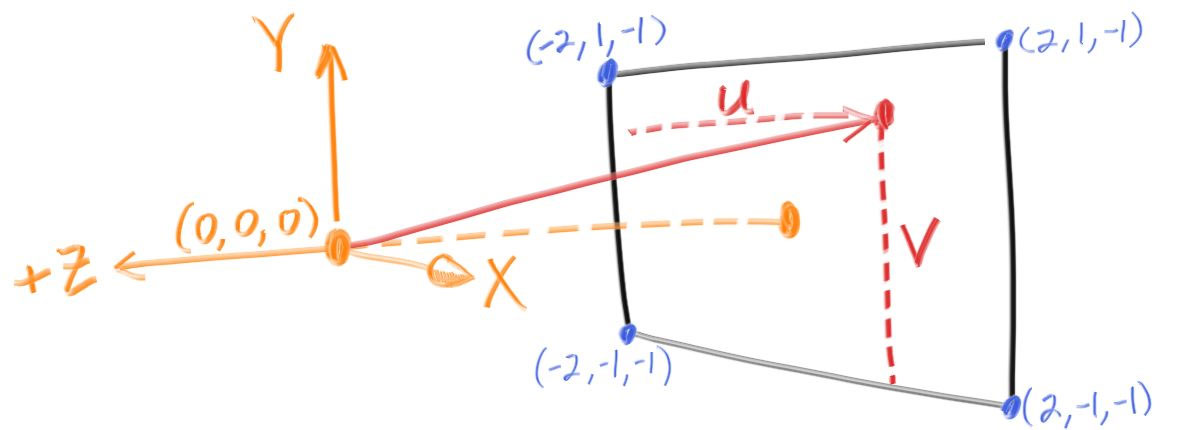

* Image from
**Ray Tracing in One Weekend**, *Peter Shirley*, 2020, https://raytracing.github.io/books/RayTracingInOneWeekend.html

In [2]:
def image_data_to_rgb(image_data, width, height):
    red_channel = 255 * jnp.clip(image_data.x, 0, 1).reshape((height, width))
    green_channel = 255 * jnp.clip(image_data.y, 0, 1).reshape((height, width))
    blue_channel = 255 * jnp.clip(image_data.z, 0, 1).reshape((height, width))
    
    return jnp.stack([red_channel, green_channel, blue_channel], axis=-1)



camera = Camera(width=400, origin=jnp.array([0., 0.05, -1.]))
demo_object = Sphere(center=Vec3(0., 0.5, 0.75), radius=0.6, diffuse=Vec3(0., 0., 1.))
scene = Scene(objects=[demo_object])
renderer = Renderer(camera=camera, scene=scene)

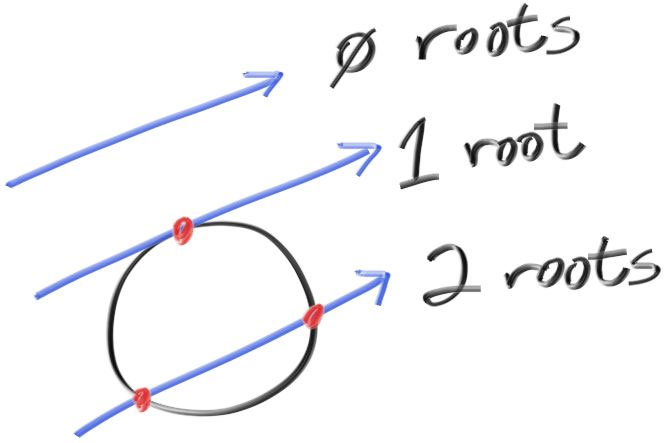


* Image from
**Ray Tracing in One Weekend**, *Peter Shirley*, 2020, https://raytracing.github.io/books/RayTracingInOneWeekend.html

Let's generate a target sphere we want to match!

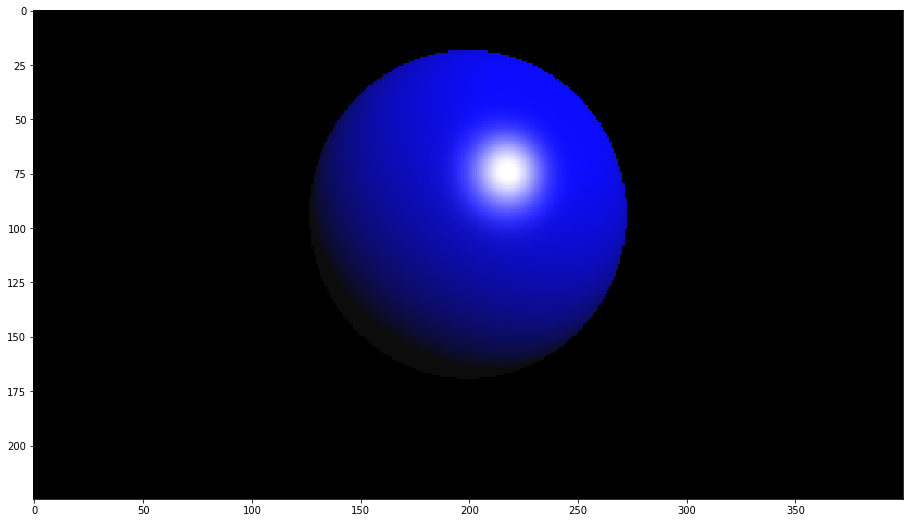

In [3]:
import matplotlib.pyplot as plt
import numpy as onp

image_data = renderer.render_fast()
image = image_data_to_rgb(image_data, camera.width, camera.height)
target = image.copy()

plt.rcParams['figure.figsize'] = [20, 9]
plt.imshow(onp.array(image) / 255.)

Let's start the color optimization from the opposite end (i.e. a red ball).

In [4]:
x = jnp.array([1., 0., 0.])
starting_point = Sphere(center=Vec3(0., 0.5, 0.75), radius=0.6, diffuse=Vec3(x[0], x[1], x[2]))

### Visualizing the starting point

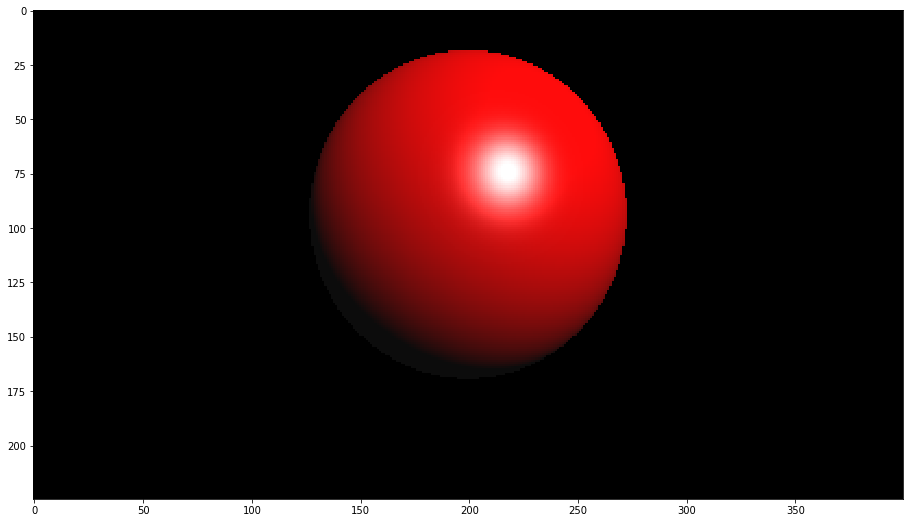

In [5]:
# We can simply update the scene directly as
renderer.scene.objects = [starting_point]
image_data = renderer.render_fast()
starting_point_image = image_data_to_rgb(image_data, camera.width, camera.height)

plt.imshow(onp.array(starting_point_image) / 255.)
plt.rcParams['figure.figsize'] = [20, 9]

### What should the loss be?

In [6]:
def loss(color):
    iterate = Sphere(center=Vec3(0., 0.5, 0.75), radius=0.6, diffuse=Vec3(color[0], color[1], color[2]))
    renderer.scene.objects = [iterate]
    iterate_image_data = renderer.render_fast()
    iterate_image = image_data_to_rgb(iterate_image_data, camera.width, camera.height)
    
    return jnp.linalg.norm(iterate_image - target)

dloss = grad(loss)

### Basic fixed step-length gradient descent

In [7]:
def save_image(color):
    iterate = Sphere(center=Vec3(0., 0.5, 0.75), radius=0.6, diffuse=Vec3(color[0], color[1], color[2]))
    renderer.scene.objects = [iterate]
    iterate_image_data = renderer.render_fast()
    iterate_image = image_data_to_rgb(iterate_image_data, camera.width, camera.height)
    return iterate_image

from tqdm import tqdm
x = jnp.array([1., 0., 0.])
train_iters = 160
lr = 1e-6

I = []
I.append(save_image(x))
for i in tqdm(range(train_iters)):
    dc = dloss(x)
    x -= lr * dc
    I.append(save_image(x))

100%|██████████| 160/160 [00:27<00:00,  5.88it/s]


### Visualize the results

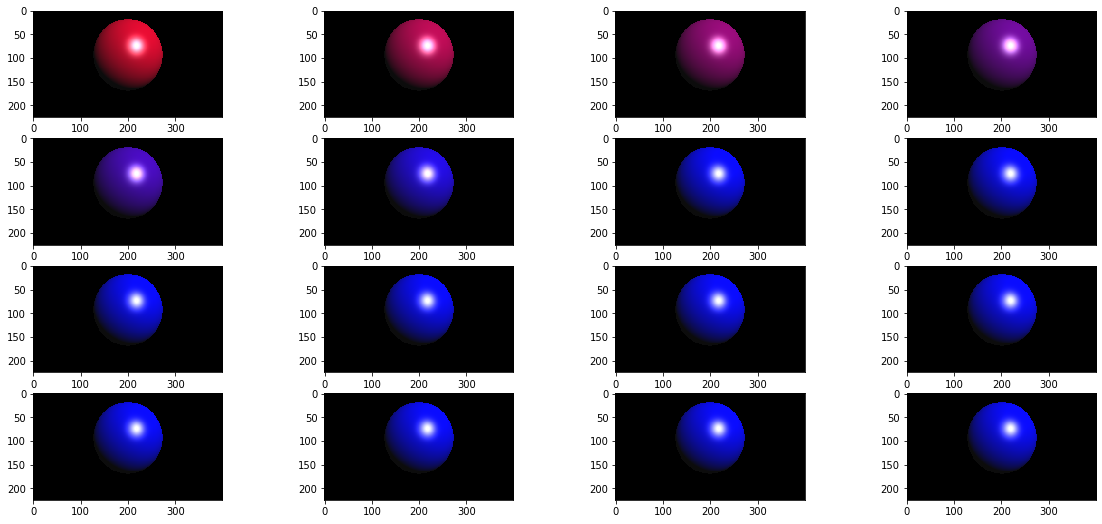

In [8]:
num_rows = 4
num_columns = 4
uniform_spacing = int(train_iters / (num_rows*num_columns))


for r in range(num_rows):
    for c in range(1, num_columns+1):
        plt.subplot(num_rows, num_columns, r*num_columns + c)
        plt.imshow(I[(r*num_columns + c) * uniform_spacing] / 255.)